# Etivity 4
* Student Name: Dylan Butler
* Student Number: 21218684

In [116]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Task 2: 
>Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. You will need to formulate a binary classification problem and transform the type column accordingly. Summarise your conclusions

## (1) EDA

In [117]:
df = pd.read_csv("./data/seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [118]:
df.type.value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

### Multi-class Problem
It is evident that there is 3 classes in this dataset. In order to train a binary classifier like SVM we need to transform the datasets target variable from multiclass back to binary. There are other solutions to this such as OneVsOneClassifier which can be used in combination with a support vector machine but here we will manually transform the target variable.

I will choose `type`==1 as the value to focus on and then convert the rest to 0

One thing to note is that this will create an unbalanced dataset

### Check for nans

In [119]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

### Check for outliers

<AxesSubplot:>

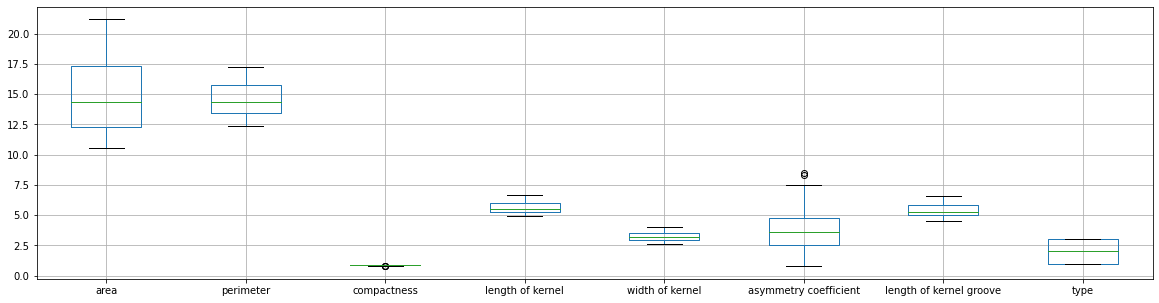

In [120]:
df.boxplot(figsize=(20,5))

Outliers not a major concern - we can apply standard scalar to our features

### Check for correlations in the data

In [121]:
import seaborn as sns

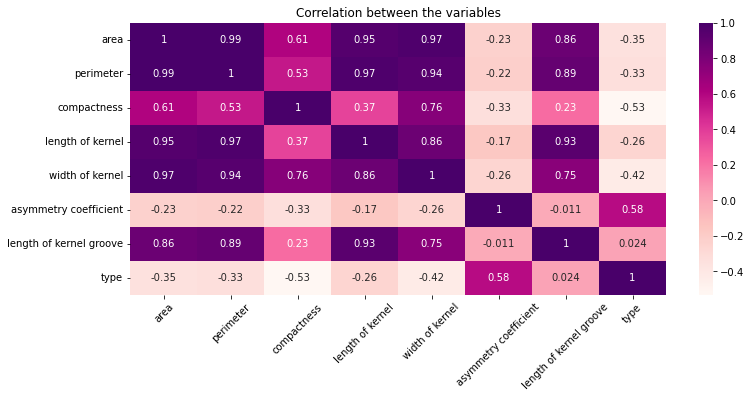

In [122]:
plt.subplots(figsize=(12,5))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)
plt.show()

We can see that a lot of the features are highly correlated - at some stage dimension reduction techniques such as PCA could be applied to the data

## Data Preparation

In [123]:
# transform the target value
df['type_trans']=np.where(df['type']!=1, 0, 1)

In [124]:
df.type_trans.value_counts()

0    140
1     70
Name: type_trans, dtype: int64

### apply scalar

In [125]:
# store a list with the names of all predictors
scale_cols = [c for c in df if c not in ['type', 'type_trans']]

In [126]:
#utilise code from example notebook
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [127]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=scale_cols),
    FeatureUnion(transformer_list=[
        ("scale_columns", make_pipeline(
            ColumnSelector(columns=scale_cols),
            StandardScaler()
        ))
    ])
)

In [128]:
X=df.drop(['type', 'type_trans'], axis=1).values
y=df.type_trans.values

### Applying Grid Search - Training

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [145]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100, 1000],  
    'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.958:
Best parameters:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


Lets apply some additional param searches for RF

In [146]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
    'rf__max_depth': [2, 4, 6, 8],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.940:
Best parameters:  {'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 31}


## Evaluating our Models

In [147]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [148]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [149]:
def print_confusion_matrix(X_test, y_test, model):
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
    #generate confusion matrix object
    cm=confusion_matrix(y_test, _predicted_values)
    #display
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()

In [150]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

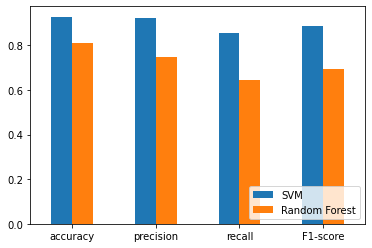

In [151]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

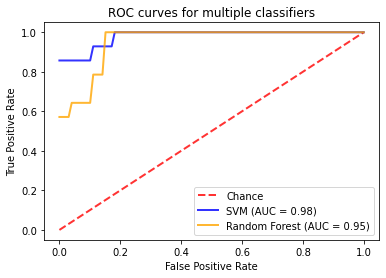

In [152]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

#### Accuracy:
> if we observe the best_score/accuracy for each model the results look promising - for SVM-0.958 and for RF-94.0.
#### Precision:
> Random Forests' precision is significantly lower compared to the SVM i.e. SVM's ability to predict positives is stronger.
#### Recall:
> Model metric to use if high cost associated with a false negative. Again, SVM wins this.
#### F1:
> Used if require a balance between precision and recall & uneven class distro.  SVM comes 1st here.

### Let's plot a confusion matrix

#### Support Vector Machine CM

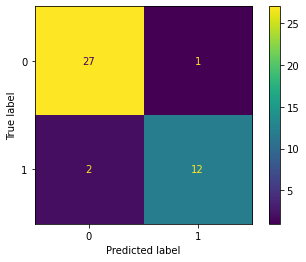

In [153]:
print_confusion_matrix(X_test, y_test, SVM_best_model)

#### Random Forest CM

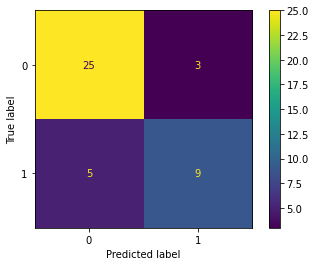

In [154]:
print_confusion_matrix(X_test, y_test, RF_best_model)

### Task 2: Conclusion

#### Target Transform:
> To convert this multiclass problem into a binary one, I converted the dataset in the following way. If the type belonged to class 2,3 a value of zero was assigned and if the value was 1 it retained its value.

#### Cost of Misclassification
> When it comes to the cost of misclassifying samples the background of the problem begins to come into play. In our case we are classifying seed types, nothing too determinetal if we get it wrong. If the problem was rather classifying a deadly virus or a natural disaster, if we even misclassify one point this can be extremely costly. 

#### SVM vs. Random Forest:
Overall, we can see that SVM outperforms the RF when we look at the evaluation metrics. 

##### Params:
* SVM:
    * I added in a couple of extra values to those from the demo notebook for C and Gamma.
* RF:
    * number estimators, max depth, max features, min samples split, min samples leaf were all explored.

# Task 3: 
> Train a third classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest. Summarise your experience with exploring the parameters (max 150 words in a markdown cell).

## KNN
For this task I will train a K-nearest neighbours model and compare the results to the two trained above. 
The reasons I have chosen Knn is:
* Slightly different to the other two algorithms as it requires no prior training to predict, lazy learning is utilised.
* New data can constantly be added because of the lazy learning aspect
* We have a low-dimensional dataset which suits knn as it does not work well with high dimensional data. 
* It works well with numerical data vs. not so well with categorical

In [155]:
from sklearn.neighbors import KNeighborsClassifier

In [190]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier(algorithm='brute'))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 17, 19, 21]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.917:
Best parameters:  {'knn__n_neighbors': 9}


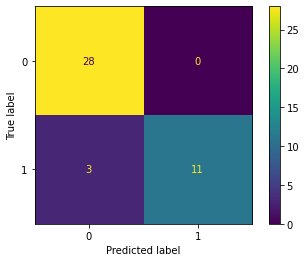

In [191]:
print_confusion_matrix(X_test, y_test, KNN_best_model)

In [193]:
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

KNN_metrics=np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

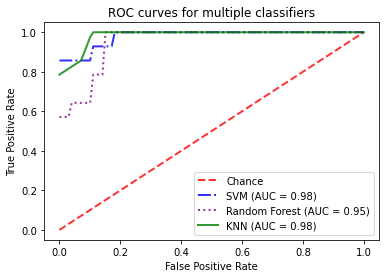

In [194]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:],linestyle='-.', lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], linestyle=':',lw=2, color='purple', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### Task 3: Conclusion
> KNN and SVM are closely tied in terms of performance on the test set, however, it has beaten Random Forest across the board. KNN outperforms SVM in percision but it's the opposite for recall and f-1 score. They have both achieved the same result when we observe the area under the curve. KNN's optimal k has been set at 9.